In [1064]:
%matplotlib notebook

import numpy as np
import math
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import interp2d
from scipy.stats import beta
import matplotlib.colors
import pandas as pd
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.patheffects as pe

plt.style.use('seaborn-whitegrid')

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


<IPython.core.display.Javascript object>


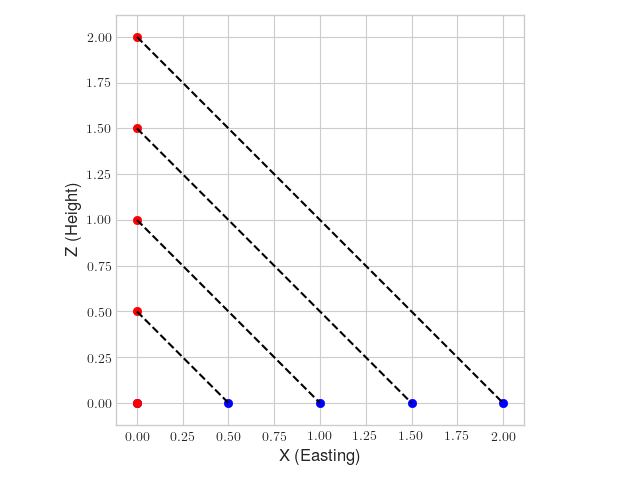

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [1065]:
fig = plt.figure()
ax = fig.add_subplot(111)

vt = -1
ux = 1

x_points = np.linspace(0,2,5)

def traj(x, vt, ux, x1, z1):
    m = vt/ux
    c = z1 - m*x1
    return m*x + c

def drop_point(x, vt, ux, x1):
    m = vt/ux
    return -m*(x - x1)

for x in x_points:
    z1 = drop_point(x, vt, ux, 0)
    xline = np.linspace(0, x, 100)
    pt = traj(xline, vt, ux, 0, z1)
    sp = ax.plot(xline, pt, "k--")
    sp = ax.scatter(x, 0, c = "b")
    sp = ax.scatter(0, z1, c = "r")
ax.set_xlabel('X (Easting)')
ax.set_ylabel('Z (Height)')
ax.set_aspect('equal', 'box')
plt.tight_layout()

In [1814]:
AIR_VISCOSITY = 0.000018325
AIR_DENSITY = 1.293
GRAVITY = 9.81

def f(x, y, sigma_sqr, x_bar, y_bar):
    return 1/(2*np.pi*sigma_sqr) * np.exp(-((x - x_bar)**2 + (y - y_bar)**2)/(2*sigma_sqr))

def part_fall_time(particle_ht, layer, ashdiam, part_density):
    hz = particle_ht # height of particle above sea level
    particle_fall_time = 0.0
    
    # rho is the density of air (kg/m^3) at the elevation of the current particle
    rho = AIR_DENSITY * np.exp(-hz/8200.0) 
    
    #  (friction due to the air) :
    #  vtl is terminal velocity (m/s) in laminar regime RE<6
    #  vti is terminal velocity (m/s) in intermediate regime 6<RE<500
    #  vtt is terminal velocity (m/s) in turbulent regime RE>500
    
    vtl = part_density * GRAVITY * ashdiam * ashdiam / (AIR_VISCOSITY * 18.0)
    
    reynolds_number = ashdiam * rho * vtl / AIR_VISCOSITY
    particle_term_vel = vtl
    temp0 = ashdiam * rho
    
    if reynolds_number >= 6.0:
        temp1 = 4.0 * GRAVITY * GRAVITY * part_density * part_density / (AIR_VISCOSITY * 225.0 * rho)
        vti = ashdiam * (temp1 ** (1./3.)) 
        reynolds_number = temp0 * vti / AIR_VISCOSITY
        particle_term_vel = vti

    # c...if intermediate RE>500 (turbulent regime), RE is calculated again considering vtt

    if reynolds_number >= 500.0:
        vtt = np.sqrt( 3.1 * part_density * GRAVITY * ashdiam / rho)
        reynolds_number =  temp0 * vtt / AIR_VISCOSITY
        particle_term_vel = vtt
    
    particle_fall_time = layer / particle_term_vel
    return (particle_fall_time, particle_term_vel)

def part_traj(x, z, wind_speed, term_vel):
    # Particle fall location based on its terminal velocity and wind speed
    # This is the x-intercept of a line 
    # with slope (-term_vel/wind_speed) 
    # that passes through a point (x, z)
    return (wind_speed/term_vel)*z + x

def conc_cloud(x, y, z, a, b, sigma_sqr, wind_speed):
    c = beta(z, a, b) * f(x, y, sigma_sqr, wind_speed, 0)
    return c

def phi_to_d(phi):
    return 2**(-phi)

In [1831]:
vt = -1
ux = 3
s = 250
u = 20
a = 3
b = 2

xx = np.linspace(-40, 225, 51)
yy = np.linspace(-100, 100, 51)
X, Y = np.meshgrid(xx, yy)

z_steps = np.linspace(10,50,5)

def landing_point(x1, z1, ux, vt):
    m = vt/ux
    return x1 - (z1/m) 

# zstep is the particle release height
# particle falls from release point (x, z) =  (0, zstep), at slope vt/ux.
# particle lands at x_bar

x_bars = landing_point(0, z_steps, ux, vt)


#Mass accumulation grid:
mass = np.zeros(X.shape)

levels = []
for zh, x_bar in zip(z_steps, x_bars):
    # Gaussian dispersal
    gauss = f(X, Y, s, x_bar, y_bar=0)
    sus_gauss = f(X, Y, s, 0, y_bar=0)
    z_norm = zh/max(z_steps)-0.000000001
    print(beta.pdf(z_norm, a, b))
    mass += gauss*beta.pdf(z_norm,a,b)
    levels.append(sus_gauss*beta.pdf(z_norm,a,b))

print(np.max(mass))







0.3839999966400002
1.1519999961599998
1.72799999856
1.5360000038399997
1.199999963661685e-08
0.0013906817097200177


<IPython.core.display.Javascript object>


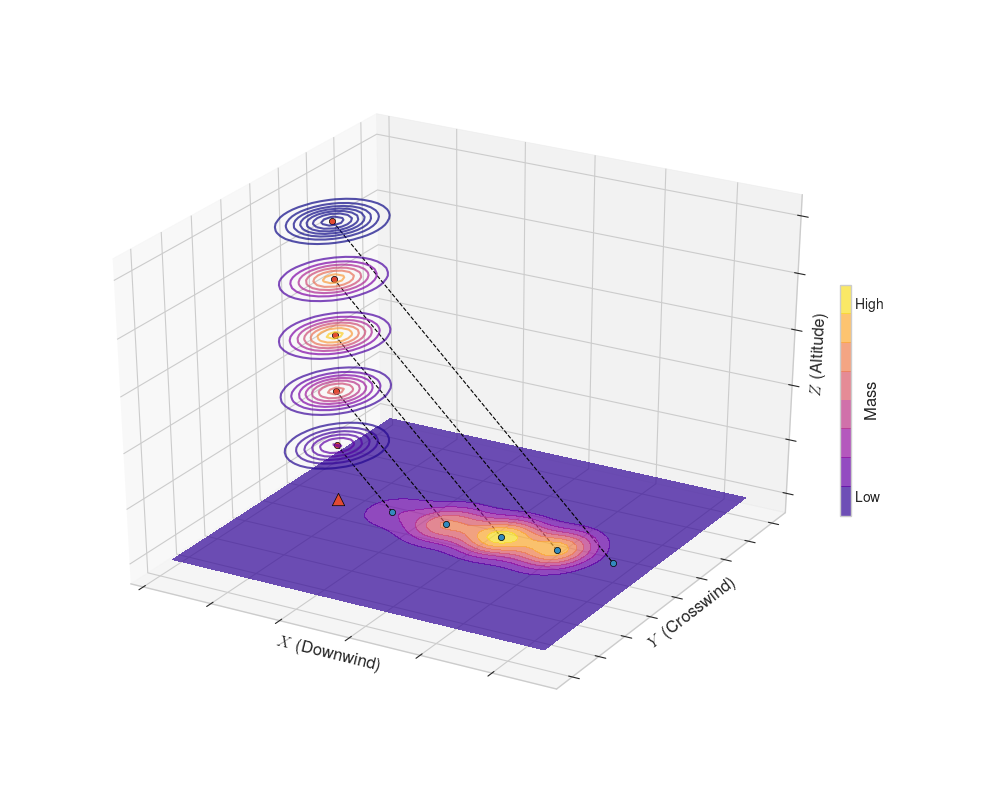

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [1827]:
# print(len(x_bars))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
im=ax.contourf(X, Y, mass, 10, cmap="plasma", alpha=0.7)
ax.scatter(0, 0, 0, marker="^", edgecolor='k', c='C0', s=80)
i = 0
for zh, x_bar in zip(z_steps, x_bars):
    xline = np.linspace(0, x_bar, 100)
    pt = traj(xline, vt, ux, 0, zh)
    sp = ax.plot(xline, [0]*len(xline),  pt, "k--", lw=.8)
    ax.scatter(x_bar, 0, 0, c='C1', edgecolors='k')
    ax.scatter(0, 0, zh, c='C0', edgecolors='k')
    ax.contour(X, Y, levels[i], cmap="plasma", offset=zh, alpha=0.7, vmin=0, vmax=np.max(mass))
    i += 1
# plt.title("Trajectory of Gaussian Centers")
ax.set_xlabel('$X$ (Downwind)', labelpad=-10)
ax.set_ylabel('$Y$ (Crosswind)', labelpad=-10)
ax.set_zlabel('$Z$ (Altitude)', labelpad=-10)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.zaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
cb = plt.colorbar(im, shrink=0.3, ticks=[0.0001,0.0011], label="Mass", pad=-0.05)
cb.ax.set_yticklabels(['Low', 'High'])
cb.ax.set_ylabel("Mass", labelpad=-15)
plt.tight_layout()
plt.savefig("Part_traj_3d.pdf", dpi=300)

<IPython.core.display.Javascript object>


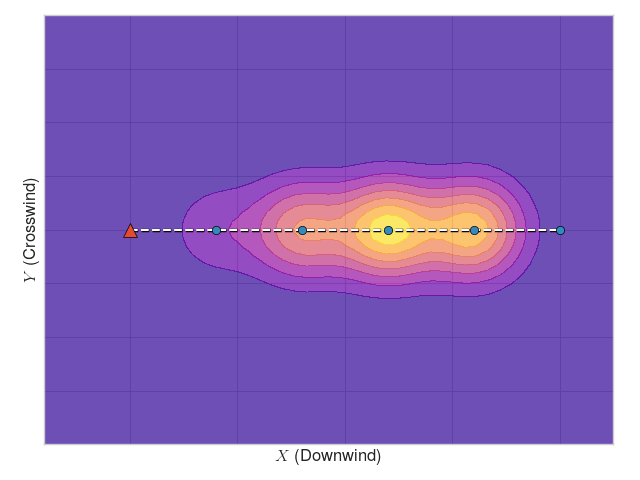

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'offset'
  s)
c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


40.0
80.0
120.0
160.0
200.0


In [1824]:
# print(len(x_bars))
fig = plt.figure()
ax = fig.add_subplot(111)
im=ax.contourf(X, Y, mass, 10, cmap="plasma", offset=0, alpha=0.7)
i = 0
for zh, x_bar in zip(z_steps, x_bars):
#     xline = np.linspace(0, x_bar, 100)
#     pt = traj(xline, vt, ux, 0, zh)
#     sp = ax.plot(xline, [0]*len(xline),  pt, "k--", lw=.8)
    print(x_bar)
    ax.scatter(x_bar, 0, c='C1', edgecolors='k', zorder=50)
#     ax.scatter(0, 0, zh, c='C0', edgecolors='k')
#     ax.contour(X, Y, levels[i], cmap="plasma", offset=zh, alpha=0.7, vmin=0, vmax=np.max(mass))
    i += 1
ax.scatter(0, 0, marker='^', s=100, edgecolors='k', zorder=100)  


locations = np.append([0], x_bars)

ax.plot(locations, [0]*len(locations), 'w--', path_effects=[pe.Stroke(linewidth=2.5, foreground='k'), pe.Normal()])


# plt.title("Trajectory of Gaussian Centers")
ax.set_xlabel('$X$ (Downwind)', labelpad=0)
ax.set_ylabel('$Y$ (Crosswind)', labelpad=0)
# ax.set_zlabel('Z (Altitude)', labelpad=-10)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')



plt.tight_layout()
plt.savefig("wind_transform_final.pdf", dpi=300)

<IPython.core.display.Javascript object>


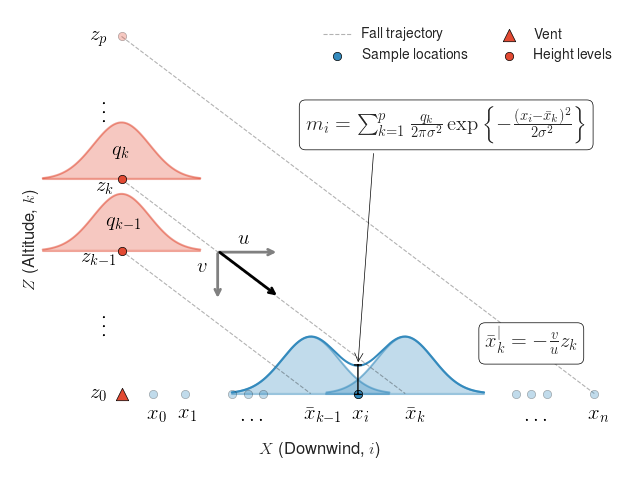

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [1832]:
# print(len(x_bars))
fig = plt.figure()
ax = fig.add_subplot(111)
i = 0
# for zh, x_bar in zip(z_steps, x_bars):

gx = np.linspace(65,115,100)

gq = gx-90

gx2 = gx-30

gmass = f(gx, 0, 80, 90, y_bar=0)

gmass2 = f(gx2, 0, 80, 60, y_bar=0)

gfull = np.linspace(35, 115, 200)

gfmass1 = f(gfull, 0, 80, 90, y_bar=0)
gfmass2 = f(gfull, 0, 80, 60, y_bar=0)

scale = 4000

plt.plot(gx, gmass*scale, alpha=0.5, c='C1') # Xbar
plt.fill(gx, gmass*scale, c='C1', alpha=0.3) 
plt.plot(gx, [0]*100, c='C1', alpha=0.5)

plt.plot(gx2, gmass2*scale, alpha=0.5, c='C1') # Xbar
plt.fill(gx2, gmass2*scale, c='C1', alpha=0.3) 
plt.plot(gx2, [0]*100, c='C1', alpha=0.5)

plt.plot(gfull, (gfmass1+gfmass2)*scale, c='C1') # Xbar
# plt.fill(gx2, gmass2*scale, c='C1', alpha=0.3) 
# plt.plot(gx2, [0]*100, c='C1', alpha=0.5)

plt.plot(gq, (gmass*scale+30), alpha=0.5, c='C0') # Qk
plt.fill(gq, (gmass*scale+30), c='C0', alpha=0.3)
plt.plot(gq, [30]*100, c='C0', alpha=0.5)

plt.plot(gq, (gmass*scale+20), alpha=0.5, c='C0') # Qk-1
plt.fill(gq, (gmass*scale+20), c='C0', alpha=0.3)
plt.plot(gq, [20]*100, c='C0', alpha=0.5)




def plot_traj(i, a=1, labels=False):
    xline = np.linspace(0, x_bars[i], 100)
    pt = traj(xline, vt, ux, 0, z_steps[i])
    if labels is False:
        sp = ax.plot(xline, pt, "k--", lw=.8, alpha=.3)
        ax.scatter(0, z_steps[i], c='C0', edgecolors='k', alpha=a, zorder=10)
    else:
        sp = ax.plot(xline, pt, "k--", lw=.8, alpha=.3, label=labels[0])
        ax.scatter(0, z_steps[i], c='C0', edgecolors='k', alpha=a, zorder=10, label=labels[1])
    
x_samps = [10, 20, 35, 40, 45, 75, 125, 130, 135, x_bars[-1]]

ax.scatter(x_samps, [0]*len(x_samps),  c='C1', edgecolors='k', zorder=10, alpha=.3)

ax.scatter(x_samps[5], [0],  c='C1', edgecolors='k', zorder=10, label="Sample locations")

ax.scatter(0, 0, marker="^", c='C0', edgecolor='k', s=80, label="Vent")
# plot_traj(0,a=.3)
plot_traj(1)

# plot_traj(3,.3)
plot_traj(4,a=.3)

plot_traj(2, labels=("Fall trajectory", "Height levels"))

plt.text(-10, -1, r'$z_0$', {'color': 'k', 'fontsize': 15})
plt.text(-10, z_steps[0]-1, r'$\cdots$', {'color': 'k', 'fontsize': 15}, rotation=90)
plt.text(-13, z_steps[1]-2, r'$z_{k-1}$', {'color': 'k', 'fontsize': 15})
plt.text(-8, z_steps[2]-2, r'$z_k$', {'color': 'k', 'fontsize': 15})
plt.text(-10, z_steps[3]-1, r'$\cdots$', {'color': 'k', 'fontsize': 15}, rotation=90)
plt.text(-10, z_steps[4]-1, r'$z_p$', {'color': 'k', 'fontsize': 15})

plt.text(-3, z_steps[2]+3, r'$q_k$', {'color': 'k', 'fontsize': 15})
plt.text(-5, z_steps[1]+3, r'$q_{k-1}$', {'color': 'k', 'fontsize': 15})

plt.text(x_samps[0]-2, -4, r'$x_0$', {'color': 'k', 'fontsize': 15})
plt.text(x_samps[1]-2, -4, r'$x_1$', {'color': 'k', 'fontsize': 15})
plt.text(x_samps[3]-2, -4, r'$\cdots$', {'color': 'k', 'fontsize': 15})
plt.text(x_samps[5]-2, -4, r'$x_i$', {'color': 'k', 'fontsize': 15})
plt.text(x_samps[7]-2, -4, r'$\cdots$', {'color': 'k', 'fontsize': 15})
plt.text(x_samps[-1]-2, -4, r'$x_n$', {'color': 'k', 'fontsize': 15})
plt.text(x_samps[5]+15, -4, r'$\bar{x}_k$', {'color': 'k', 'fontsize': 15})
plt.text(x_samps[5]-17, -4, r'$\bar{x}_{k-1}$', {'color': 'k', 'fontsize': 15})

# plt.text(x_samps[5]-10, -4, r'&\bar{x}&', {'color': 'k', 'fontsize': 15})

ax.annotate("",
            xy=(50, 19.8), xycoords='data',
            xytext=(30, 19.8), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", 
                            edgecolor='gray', lw=2),
            )

ax.annotate("",
            xy=(30.5, 13), xycoords='data',
            xytext=(30.5, 20), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", 
                            edgecolor='gray', lw=2),
            )

ax.annotate("",
            xy=(50, 13.5), xycoords='data',
            xytext=(30.5, 20), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", 
                            edgecolor='k', lw=2),
            )

ax.annotate("",
            xy=(75, 4.4), xycoords='data',
            xytext=(75, -0.5), textcoords='data',
            arrowprops=dict(arrowstyle='|-|, widthA=0.25, widthB=0.25',
                            connectionstyle="arc3", 
                            edgecolor='k', lw=1, 
                            ),
            zorder=1000)

ax.annotate("",
            xy=(75, 4), xycoords='data',
            xytext=(80, 34), textcoords='data',
            fontsize=15,
            arrowprops=dict(arrowstyle='->', 
                            edgecolor='k', lw=.5, 
                            ),
            zorder=1000)

# plt.text(50, 38, r'$m_i=\sum_{k=1}^p \frac{q_k}{2\pi\sigma^2} \exp\left\{-\frac{(x_i-\bar{x}_k)^2}{2\sigma^2}\right\}$',
#          {'color': 'k', 'fontsize': 15})

ax.annotate(r'$m_i=\sum_{k=1}^p \frac{q_k}{2\pi\sigma^2} \exp\left\{-\frac{(x_i-\bar{x}_k)^2}{2\sigma^2}\right\}$', 
            xy=(103, 35), xycoords="data",
            fontsize=15,
            va="bottom", ha="center",
            bbox=dict(boxstyle="round", fc="w", ec='k'))

ax.annotate(r'$\bar{x}_k^{|} = -\frac{v}{u}z_k$', xy=(130, 5), xycoords="data",
            fontsize=15,
            va="bottom", ha="center",
            bbox=dict(boxstyle="round", fc="w", ec='k'))

# plt.text(25, 5, ,
#          {'color': 'k', 'fontsize': 15}, 
#          bbox=dict(facecolor='w', ec='k', height=0.5))

plt.text(37, 21, r'$u$', {'color': 'k', 'fontsize': 15})
plt.text(24, 17, r'$v$', {'color': 'k', 'fontsize': 15})

#     ax.contour(X, Y, levels[i], cmap="plasma", offset=zh, alpha=0.7, vmin=0, vmax=np.max(mass))
# plt.title("Trajectory of Gaussian Centers")
ax.set_xlabel(r'$X$ (Downwind, $i$)',labelpad=-20)
ax.set_ylabel(r'$Z$ (Altitude, $k$)',labelpad=-20)
ax.set_ylim(bottom=-10)
# ax.set_zlabel('Z (Altitude)', labelpad=-10)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
# ax.set_aspect('equal', 'box')
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.grid(False)
# plt.axis("off")
plt.legend(ncol=2)
plt.show()
plt.savefig("diagram.pdf", dpi=300)

<IPython.core.display.Javascript object>


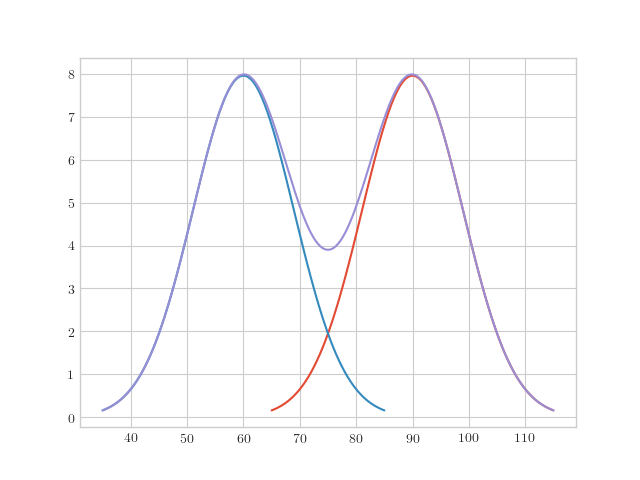

In [1731]:
plt.figure()

plt.plot(gx, gmass*scale)
plt.plot(gx2, gmass*scale)

gfull = np.linspace(35, 115, 200)

gmass1 = f(gfull, 0, 80, 90, y_bar=0)
gmass2 = f(gfull, 0, 80, 60, y_bar=0)

# plt.plot(gfull, gmass1*scale)
# plt.plot(gfull, gmass2*scale)

plt.plot(gfull, (gmass1+gmass2)*scale)

plt.show()

<IPython.core.display.Javascript object>


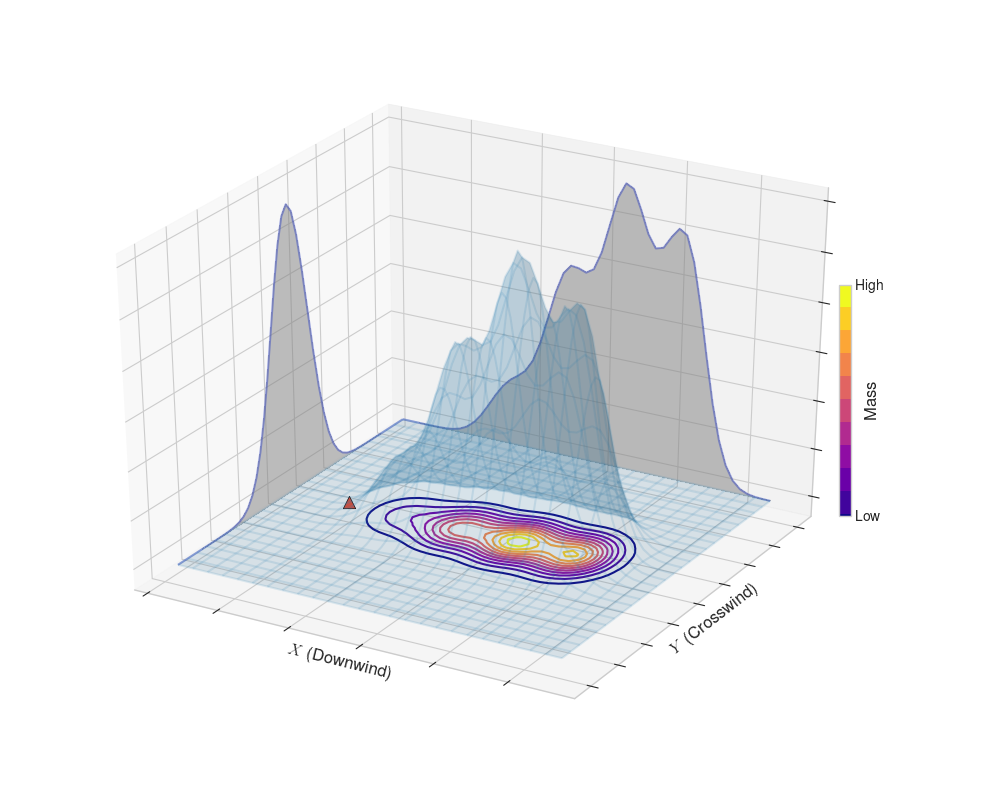

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [1826]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

ax.plot_wireframe(X, Y, mass, alpha=0.15, color='C1')
ax.plot_surface(X, Y, mass, alpha=0.15, color='C1')
ax.scatter(0, 0, 0, marker="^", edgecolor='k', c='C0', s=80)
csetxy = ax.contour(X, Y, mass, 12, zdir='z', offset=0, cmap="plasma")

csetyz = ax.contourf(X, Y, mass, zdir='x', offset=-40, cmap="gray", levels=[-150, 120], alpha=0.5)
csetxz = ax.contourf(X, Y, mass, zdir='y', offset=100, cmap="gray", levels=[-150, 0], alpha=0.5)
csetyz = ax.contour(X, Y, mass, zdir='x', offset=-40, cmap="coolwarm", levels=[120], alpha=0.5)
csetxz = ax.contour(X, Y, mass, zdir='y', offset=100, cmap="coolwarm", levels=[0], alpha=0.5)



ax.set_xlabel('$X$ (Downwind)', labelpad=-10)
ax.set_ylabel('$Y$ (Crosswind)', labelpad=-10)


frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.zaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
cb=plt.colorbar(csetxy, shrink=0.3, pad=-0.08, ticks=[0.0001,0.0011])
# cb = plt.colorbar(csetxy, shrink=0.3, ticks=[np.min(mass),np.max(mass)], label="Mass", pad=-0.08)
cb.ax.set_yticklabels(['Low', 'High'])
cb.ax.get_children()[0].set_linewidths(31.0)
cb.ax.set_ylabel("Mass", labelpad=-15)
plt.tight_layout()
plt.grid(False)
# plt.show()
plt.savefig("contours_mesh.pdf", dpi=300)

<IPython.core.display.Javascript object>


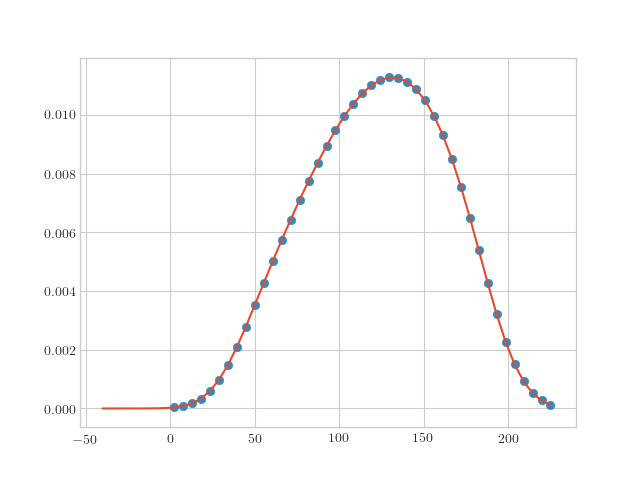

[-40.  -34.7 -29.4 -24.1 -18.8 -13.5  -8.2  -2.9   2.4   7.7  13.   18.3
  23.6  28.9  34.2  39.5  44.8  50.1  55.4  60.7  66.   71.3  76.6  81.9
  87.2  92.5  97.8 103.1 108.4 113.7 119.  124.3 129.6 134.9 140.2 145.5
 150.8 156.1 161.4 166.7 172.  177.3 182.6 187.9 193.2 198.5 203.8 209.1
 214.4 219.7 225. ]
43


In [1585]:
plt.figure()

ymin = np.argmin(np.abs(Y[:,0]))

X_line = X[ymin,:]
print(X_line)
true_M = mass[ymin,:]

plt.plot(X_line, true_M)

X_trunc = X_line[X_line > 0]
M_trunc = true_M[X_line > 0]

samp_skip = 1

X_samp = X_trunc[::samp_skip]
M = M_trunc[::samp_skip]


######### Making it length 10 here for

# X_samp = X_samp[1:]

# M = M[1:]

##########
plt.scatter(X_samp, M, c="C1")

n = len(X_samp)
p = n
print(n)

plt.show()

In [1654]:


x_max = X_samp[-1]

z_max = (-ux/vt)*X_samp[-1]

z_line = np.linspace(1, 80, p)

print(z_line)

X_bars = (-vt/ux)*z_line

A = np.zeros((n, p))
X_samp.size
for i in range(n-1):
    for k in range(p-1):
#         A[i,k] = (1/(2*np.pi*(s**2))) * np.exp(-(((X_samp[i] - X_bars[k])**2)/(2*(s**2))))
        A[i,k] = f(X_samp[i], 0, s**2, X_bars[k], 0)


[ 1.          2.88095238  4.76190476  6.64285714  8.52380952 10.4047619
 12.28571429 14.16666667 16.04761905 17.92857143 19.80952381 21.69047619
 23.57142857 25.45238095 27.33333333 29.21428571 31.0952381  32.97619048
 34.85714286 36.73809524 38.61904762 40.5        42.38095238 44.26190476
 46.14285714 48.02380952 49.9047619  51.78571429 53.66666667 55.54761905
 57.42857143 59.30952381 61.19047619 63.07142857 64.95238095 66.83333333
 68.71428571 70.5952381  72.47619048 74.35714286 76.23809524 78.11904762
 80.        ]


[-3.88314306e+14 -1.05870587e+14  7.89208458e+13  1.84055056e+14
  2.30551390e+14  2.30167421e+14  1.98659389e+14  1.46120091e+14
  8.29133972e+13  1.65193188e+13 -4.60222083e+13 -1.01226544e+14
 -1.44937524e+14 -1.75703961e+14 -1.90912923e+14 -1.91972218e+14
 -1.79381369e+14 -1.53997362e+14 -1.19153699e+14 -7.60177745e+13
 -2.71630356e+13  2.25691459e+13  7.05747183e+13  1.14838454e+14
  1.51042769e+14  1.78067580e+14  1.91563356e+14  1.91764471e+14
  1.78102334e+14  1.48480110e+14  1.05315845e+14  5.07368540e+13
 -1.20888027e+13 -7.83224396e+13 -1.42830317e+14 -1.96892339e+14
 -2.30220458e+14 -2.31829137e+14 -1.87775712e+14 -8.22009031e+13
  1.02885897e+14  3.88985175e+14  0.00000000e+00]
(43, 43)
(43,)
(43,)
(43,)


c:\users\nmostert\envs\spew\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


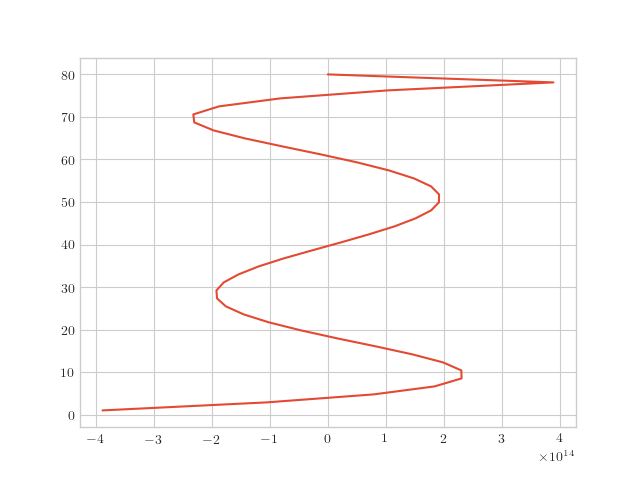

[10.         10.95238095 11.9047619  12.85714286 13.80952381 14.76190476
 15.71428571 16.66666667 17.61904762 18.57142857 19.52380952 20.47619048
 21.42857143 22.38095238 23.33333333 24.28571429 25.23809524 26.19047619
 27.14285714 28.0952381  29.04761905 30.         30.95238095 31.9047619
 32.85714286 33.80952381 34.76190476 35.71428571 36.66666667 37.61904762
 38.57142857 39.52380952 40.47619048 41.42857143 42.38095238 43.33333333
 44.28571429 45.23809524 46.19047619 47.14285714 48.0952381  49.04761905
 50.        ]


In [1655]:
from numpy.linalg import inv

Q = np.linalg.lstsq(A, M)[0]
print(Q)

print(shape(A))
print(shape(M))
print(shape(Q))
print(shape(z_line))

plt.figure()
plt.plot(Q, z_line)

print(z_steps)

plt.show()


<IPython.core.display.Javascript object>


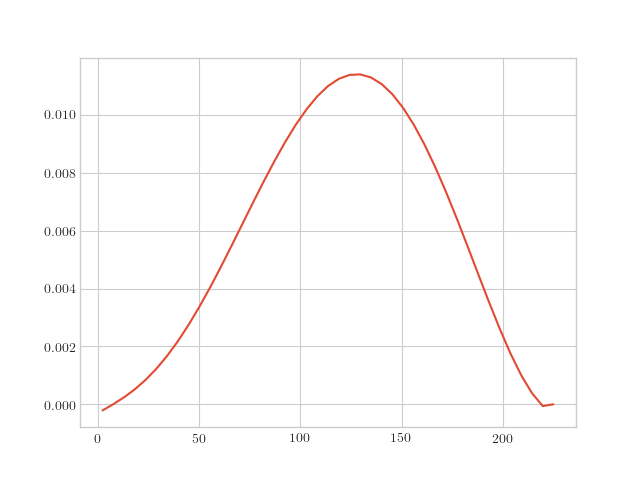

In [1656]:
M_back = np.matmul(A, Q)

plt.figure()

plt.plot(X_samp, M_back)
# plt.plot(X_line, true_M)

plt.show()

<IPython.core.display.Javascript object>


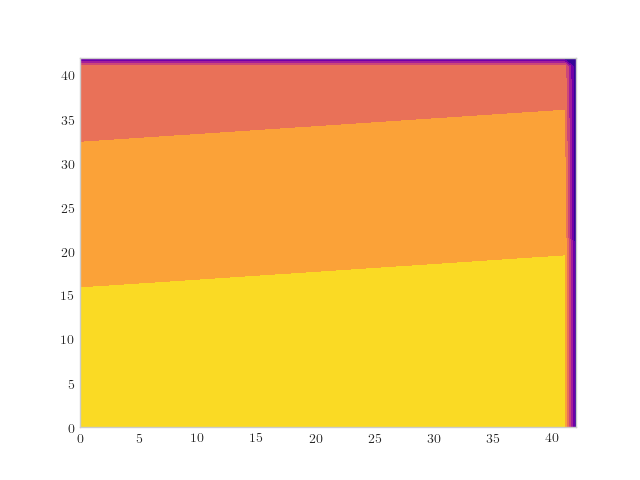

In [1657]:
plt.figure()

plt.contourf(A, cmap="plasma")

plt.show()

3
2
100.00000000000001


<IPython.core.display.Javascript object>


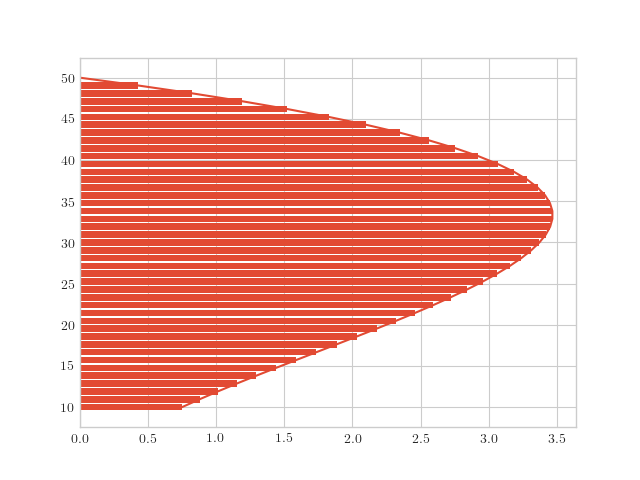

In [1658]:
print(a)
print(b)
q_beta = beta(a,b)

max_height = max(z_steps)
z_norm = z_steps/max_height

pdf = q_beta.pdf(z_norm)

pdf_sum = sum(q_beta.pdf(z_norm))

norm_beta = q_beta.pdf(z_norm)/pdf_sum
tot_mass = 100
mass_dist = norm_beta * tot_mass

print(sum(mass_dist))

plt.figure()
plt.plot(mass_dist, z_steps)
plt.barh(z_steps, mass_dist)
plt.show()




<IPython.core.display.Javascript object>


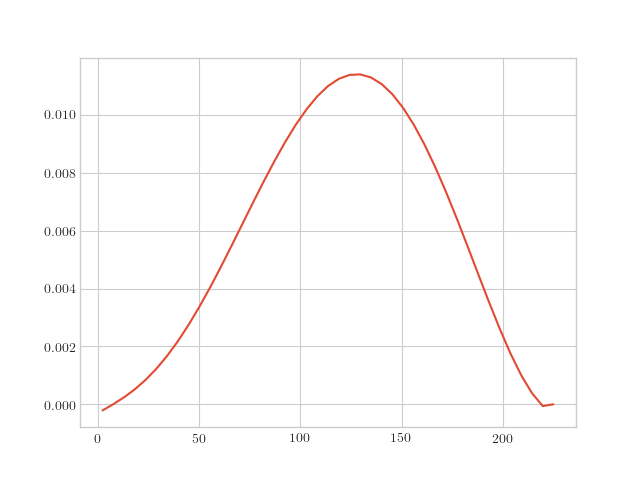

In [1659]:
Q_forward = mass_dist

A_forward = A



M_forward = np.matmul(A, Q)

sum(M_forward)


plt.figure()
plt.plot(X_samp, M_forward)
# plt.plot(X_line, true_M)
plt.show()

[-3.88192328e+14 -1.05837272e+14  7.88961372e+13  1.83997320e+14
  2.30479029e+14  2.30095151e+14  1.98596981e+14  1.46074151e+14
  8.28872793e+13  1.65140301e+13 -4.60078698e+13 -1.01194875e+14
 -1.44892125e+14 -1.75648889e+14 -1.90853056e+14 -1.91911993e+14
 -1.79325070e+14 -1.53949000e+14 -1.19116247e+14 -7.59938349e+13
 -2.71544067e+13  2.25621839e+13  7.05527015e+13  1.14802551e+14
  1.50995500e+14  1.78011821e+14  1.91503343e+14  1.91704371e+14
  1.78046490e+14  1.48433525e+14  1.05282765e+14  5.07208608e+13
 -1.20851205e+13 -7.82980077e+13 -1.42785669e+14 -1.96830740e+14
 -2.30148395e+14 -2.31756541e+14 -1.87716880e+14 -8.21751020e+13
  1.02853763e+14  3.88863464e+14  0.00000000e+00]


<IPython.core.display.Javascript object>


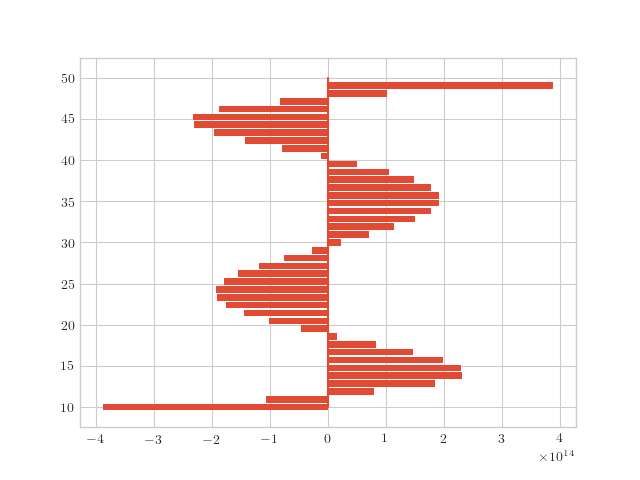

In [1661]:
Q_back = np.linalg.lstsq(A_forward, M_forward, rcond=None)[0]

print(Q_back)

plt.figure()
plt.plot(mass_dist, z_steps)
plt.barh(z_steps, Q_back)
plt.show()


In [1561]:
# from context import spew
# from shapely.geometry import Point

# erp = spew.core.eruption.Eruption(data="const_wind_test.txt", vent=Point(0, 0), test=False)

# fig, ax = erp.plot_contour(background='gradient', cmap="plasma", 
#                                         line_colors="k", title="Simulated Eruption")
# plt.savefig("sim_contours.png", dpi=300)

In [1041]:
# Z_sim = erp.df.pivot("Easting", "Northing", "MassArea").values
# x_vals = erp.df.Easting.drop_duplicates().values
# y_vals = erp.df.Northing.drop_duplicates().values
# X_sim, Y_sim = np.meshgrid(x_vals, y_vals)

In [1562]:
# fig = plt.figure()
# ax = fig.gca(projection='3d')

# ax.plot_wireframe(X_sim, Y_sim, np.log10(Z_sim), alpha=0.1)
# ax.plot_surface(X_sim, Y_sim, np.log10(Z_sim), alpha=0.1)
# cset = ax.contour(X_sim, Y_sim, np.log10(Z_sim), zdir='z', offset=-4.5, cmap="plasma")
# cset = ax.contour(X_sim, Y_sim, np.log10(Z_sim), zdir='x', offset=-100000, cmap="plasma")
# cset = ax.contour(X_sim, Y_sim, np.log10(Z_sim), zdir='y', offset=100000, cmap="plasma")

# ax.set_title('Profile Contours of Simulated Eruption')

# ax.set_xlabel('X (Easting)')
# # ax.set_xlim(-40, 40)
# ax.set_ylabel('Y (Northing)')
# # ax.set_ylim(-40, 10000)
# ax.set_zlabel('Z (Height)')
# # ax.set_zlim(-100, 100)

# plt.show()
# plt.savefig("sim_profiles.png", dpi=300)

In [1563]:
# plt.figure()
# erp.df[erp.phi_labels].mean().plot.bar()
# plt.tight_layout()
# plt.show()

In [1564]:
# print(len(erp.df))
# x_sample = erp.df[erp.df["Northing"]==0]
# print(len(x_sample))
# plt.figure()
# plt.plot(x_sample["Easting"], x_sample["MassArea"])
# plt.title("Total Mass Deposited Along X-axis")
# plt.ylabel("Mass/Area")
# plt.xlabel("X (Easting)")
# plt.show()



# for i, phi in enumerate(erp.phi_labels):
#     plt.figure()
#     mass = x_sample["MassArea"]*x_sample[phi]
#     plt.plot(x_sample["Easting"].values[90:], mass.values[90:])
#     plt.scatter(x_sample["Easting"].values[100::2], mass.values[100::2])
#     plt.title(phi)
#     plt.title("Total Mass for Phi class %s"%phi)
#     plt.ylabel("Mass/Area")
#     plt.xlabel("X (Easting)")
#     plt.savefig("mass_on_floor_%d.png"%i, dpi=300)

In [1565]:
# ux = 10
# sample = x_sample[100::2]
# display(sample["Easting"].values)
# matrix = pd.DataFrame(columns=sample["Easting"].values)
# display(sample)
# heightmap = pd.DataFrame(columns=['Height', 'Mass'])
# for phi, phi_lab, j in zip(erp.phi_centroids, erp.phi_labels, range(len(erp.phi_labels))):
#     d = phi_to_d(phi)
#     ft, vt = part_fall_time(particle_ht=12500, layer=12500, ashdiam=d/1000, part_density=1850)
#     m = -vt/ux
#     print(phi, d, vt, m)
#     plt.figure()
#     for i, row in sample.iterrows():
#         x = row["Easting"]
#         height = -m*x
#         mass = row["MassArea"]*row[phi_lab]
#         print(mass, height)
# #         if (mass > 1):
#         plt.scatter(mass, height, color='C0')
#         heightmap = heightmap.append({'Height': height, 'Mass': mass}, ignore_index=True)
#     plt.title("Mass in column for phi class %s"%phi_lab)
#     plt.ylabel("Altitude (m)")
#     plt.xlabel("Suspended Mass (kg)")
#     plt.savefig("mass_in_col_%d.pdf"%j)

In [1570]:
# heightmap.plot.scatter(x = 'Mass', y = 'Height')
# heightmap.hist(column="Height", data='Mass', bins=25)



# hm = heightmap[heightmap["Height"] < 40000]

In [1567]:
# hm['Height'] = pd.cut(hm['Height'], bins=20)
# display(hm)

c:\users\nmostert\envs\spew\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Height,Mass
0,"(-39.897, 1994.842]",200499.802220
1,"(9974.208, 11969.05]",146540.057621
2,"(21943.259, 23938.1]",62911.996917
3,"(33912.309, 35907.15]",20999.266223
51,"(-39.897, 1994.842]",346776.304920
52,"(7979.367, 9974.208]",351476.732851
53,"(15958.734, 17953.575]",226748.434287
54,"(23938.1, 25932.942]",107659.917438
55,"(31917.467, 33912.309]",44353.784333
102,"(-39.897, 1994.842]",449589.022120


In [1568]:
# heights = hm.groupby(['Height']).sum()

<IPython.core.display.Javascript object>


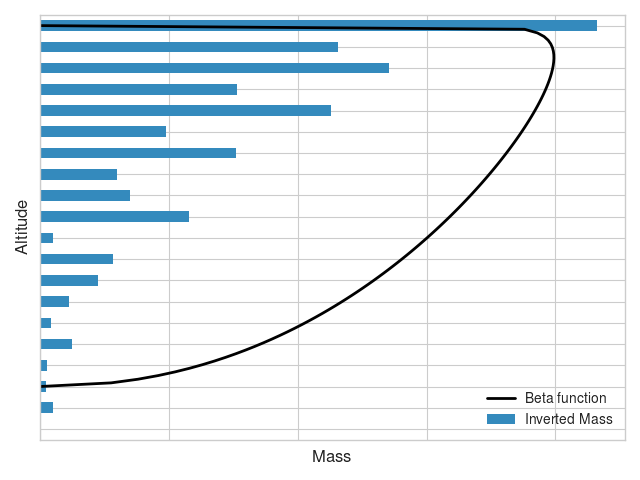

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [1683]:
rv = beta(1.04487, 1.46425)
x = np.linspace(0,1,100)
fig = plt.figure()
ax = fig.gca()
ax.plot(rv.pdf(x)*3000000, x*17, 'k-', lw=2, label='Beta function')



heights.plot.barh(ax=ax, color='C1')
ax.legend(["Beta function", "Inverted Mass"])

plt.xlabel("Mass")
plt.ylabel("Altitude")
ax.invert_yaxis()
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.tight_layout()
plt.savefig("recon_col.pdf", dpi=300)

In [1829]:
vt = -1
ux = [3]*5
uy = [0.2, 0.8, 1.5, 2, 2.5]
s = 300
u = 20
a = 3
b = 2

xx = np.linspace(-50, 200, 50)
yy = np.linspace(-50, 150, 50)
X, Y = np.meshgrid(xx, yy)

z_steps = np.linspace(10,50,5)

def landing_point(p1, z1, u, vt):
    m = [vt/ui for ui in u]
    locs = [p1 - (zi/mi) for zi, mi in zip(z1, m)]
    return locs

# zstep is the particle release height
# particle falls from release point (x, z) =  (0, zstep), at slope vt/ux.
# particle lands at x_bar

x_bars = landing_point(0, z_steps, ux, vt)
y_bars = landing_point(0, z_steps, uy, vt)
print(x_bars)
print(y_bars)
#Mass accumulation grid:
mass = np.zeros(X.shape)

levels = []
for zh, x_bar, y_bar in zip(z_steps, x_bars, y_bars):
    # Gaussian dispersal
    gauss = f(X, Y, s, x_bar, y_bar=y_bar)
    sus_gauss = f(X, Y, s, 0, y_bar=0)
    z_norm = zh/max(z_steps)-0.000000001
    print(beta.pdf(z_norm, a, b))
    mass += gauss*beta.pdf(z_norm,a,b)
    levels.append(sus_gauss*beta.pdf(z_norm,a,b))

print(np.max(mass))



[30.0, 60.0, 90.0, 120.0, 150.0]
[2.0, 16.0, 45.0, 80.0, 125.0]
0.3839999966400002
1.1519999961599998
1.72799999856
1.5360000038399997
1.199999963661685e-08
0.0009699177214628897


<IPython.core.display.Javascript object>


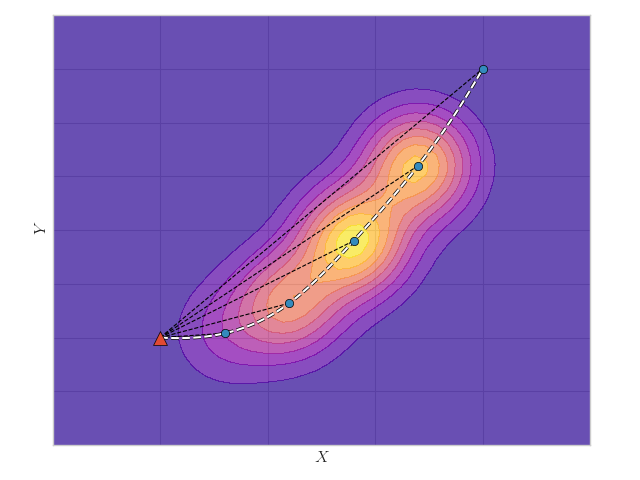

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'offset'
  s)
c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [1830]:


def traj3D(x, y, vt, ux, uy, x1, y1, z1):
    mx = vt/ux
    my = vt/uy
    c =  z1 - mx*x1 - my*y1
    return mx*x + c




# print(len(x_bars))
fig = plt.figure()
ax = fig.add_subplot(111)
im=ax.contourf(X, Y, mass, 10, cmap="plasma", offset=0, alpha=0.7)
i = 0
for zh, x_bar, y_bar, ui, uj in zip(z_steps, x_bars, y_bars, ux, uy):
    xline = np.linspace(0, x_bar, 100)
    yline = np.linspace(0, y_bar, 100)
    pt = [traj3D(x, y, vt, ui, uj, 0, 0, zh) for x, y in zip(xline, yline)]

    sp = ax.plot(xline, yline, "k--", lw=.8)
    ax.scatter(x_bar, y_bar, c='C1', edgecolors='k', zorder=100)
    i += 1
ax.scatter(0, 0, marker='^', s=100, edgecolors='k', zorder=100)  

xnew = np.linspace(0,max(x_bars),300) #300 represents number of points to make between T.min and T.max

spl = make_interp_spline([0]+x_bars, [0]+y_bars, k=3) #BSpline object
power_smooth = spl(xnew)

ax.plot(xnew,power_smooth, 'w--', path_effects=[pe.Stroke(linewidth=2.5, foreground='k'), pe.Normal()])

# plt.title("Trajectory of Gaussian Centers")
ax.set_xlabel('$X$', labelpad=0)
ax.set_ylabel('$Y$', labelpad=0)
# ax.set_zlabel('Z (Altitude)', labelpad=-10)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
# plt.colorbar(im, shrink=0.5, ticks=[], label="Mass", pad=0.025)
plt.tight_layout()
plt.savefig("wind_transform_1.pdf", dpi=300)